In [80]:
from glasspy.predict.models import GlassNet
from glasspy.data import SciGlass, sciglass_dbinfo
from glasspy.chemistry.convert import to_array, wt_to_mol

from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
from scipy.stats import pearsonr, kendalltau, zscore
from scipy.constants import pi
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [81]:
def get_gs(df, tm = 'Tl', jez=False):
    df['K_W_Tc'] = (df.Tc - df.Tg) / df[tm] # best one in the paper
    df['K_W_Tx'] = (df.Tx - df.Tg) / df[tm]
    df['gamma_Tc'] = df.Tc / (df.Tg+df.Tl)
    df['H_prime_Tx'] = (df.Tx - df.Tg) / df.Tg
    df['K_H_Tc'] = (df.Tc - df.Tg) / (df[tm] - df.Tc) # replaced Tmelt with Tliq
    df['H_prime_Tc'] = (df.Tc - df.Tg) / df.Tg
    df['K_H_Tx'] = (df.Tx - df.Tg) / (df[tm] - df.Tx) # replaced Tmelt with Tliq
    df['deltaT_rg'] = (df.Tx - df.Tg) / (df.Tl - df.Tg)
    df['K_cr'] = (df.Tl - df.Tx) / (df.Tl - df.Tg)
    if jez:
        df['Jezica'] = (df.ViscosityAtTl) - 2 * np.log10(df.Tl)
    return df
    
def get_eta_tl(df):
    return df['log10 (η∞)'] + (12-df['log10 (η∞)'])*(df.T12/df.Tl)*np.exp((df.m/(12-df['log10 (η∞)'])-1)*(df.T12/df.Tl - 1))
    
def get_gfa(df, logXs = -2, logNs = 3, g=pi, **kw):
    Umax = 10 ** df.log_Umax
    
    tn = (10**logXs / (g * 10**logNs * Umax**2))**(1 / 2)

    df['GFA'] = -np.log10((df.Tl - df.T_Umax) / tn)
    return df

In [82]:
glassnet_stnn = GlassNet()
glassnet_train_df = glassnet_stnn.get_training_dataset()
glassnet_test_df = glassnet_stnn.get_test_dataset()

In [83]:
X_glassnet_test = glassnet_test_df.elements
X_glassnet_train = glassnet_train_df.elements
X_glassnet_total = pd.concat( (X_glassnet_train, X_glassnet_test) )

In [84]:
X_glassnet_feats_test, feats = glassnet_stnn.featurizer(X_glassnet_test, return_cols = True)
X_glassnet_feats_train, feats = glassnet_stnn.featurizer(X_glassnet_train, return_cols = True)

In [85]:
X_glassnet_feats_test = pd.DataFrame(X_glassnet_feats_test, columns = feats)
X_glassnet_feats_train = pd.DataFrame(X_glassnet_feats_train, columns = feats)

In [86]:
X_glassnet_feats_test.index = X_glassnet_test.index
X_glassnet_feats_train.index = X_glassnet_train.index

In [87]:
X_glassnet_feats_total = pd.concat( (X_glassnet_feats_train, X_glassnet_feats_test) )

In [88]:
y_glassnet_test = glassnet_test_df.property.rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tl'})
y_glassnet_train = glassnet_train_df.property.rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tl'})

In [89]:
y_glassnet_train['ViscosityAtTl'] = glassnet_stnn.predict_log10_viscosity(T = y_glassnet_train.Tl,
                                                                          composition = X_glassnet_train)

In [90]:
y_glassnet_test['ViscosityAtTl'] = glassnet_stnn.predict_log10_viscosity(T = y_glassnet_test.Tl,
                                                                          composition = X_glassnet_test)

/Users/sarahisabelallec/opt/anaconda3/envs/glassnet_0_4_6/lib/python3.10/site-packages/scipy/optimize/_lsq/least_squares.py:221: RuntimeWarning: overflow encountered in square
  z = (f / f_scale) ** 2


In [91]:
y_glassnet_total = pd.concat( (y_glassnet_train, y_glassnet_test) )

In [92]:
gs_glassnet_train = get_gs(y_glassnet_train, jez=True)
gs_glassnet_test = get_gs(y_glassnet_test, jez=True)

In [93]:
gfa_glassnet_train = get_gfa(y_glassnet_train)['GFA'].replace([np.inf, -np.inf], np.nan).dropna()
gfa_glassnet_test = get_gfa(y_glassnet_test)['GFA'].replace([np.inf, -np.inf], np.nan).dropna()

/Users/sarahisabelallec/opt/anaconda3/envs/glassnet_0_4_6/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sarahisabelallec/opt/anaconda3/envs/glassnet_0_4_6/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/sarahisabelallec/opt/anaconda3/envs/glassnet_0_4_6/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [94]:
gs_glassnet_total = pd.concat( (gs_glassnet_train, gs_glassnet_test ) )
gfa_glassnet_total = pd.concat( (gfa_glassnet_train, gfa_glassnet_test) )

In [95]:
gs_cols = ['K_W_Tc', 'gamma_Tc', 'H_prime_Tc', 'Jezica']
gs_titles = [r'$K_{W}(T_{c})$', r'$\gamma(T_{c})$', r'$H^{\prime}(T_{c})$', '$JEZ$']

In [96]:
NaFePO_df= pd.read_csv('WS_Na2O_ADD_Fe2O3-P2O5.csv')
at_perc_df = NaFePO_df[ ['Na2O at %', 'Fe2O3 at %', 'P2O5 at %'] ] / 100
at_perc_df.columns = at_perc_df.columns.str.strip(' at %')
at_chem_arr = to_array(at_perc_df)
at_chem_arr

ChemArray
['Na2O', 'Fe2O3', 'P2O5']
[[0.    0.    1.   ]
 [0.    0.025 0.975]
 [0.    0.05  0.95 ]
 ...
 [0.975 0.    0.025]
 [0.975 0.025 0.   ]
 [1.    0.    0.   ]]


In [97]:
X_glassnet_feats_NaFePO, feats = glassnet_stnn.featurizer(at_chem_arr, return_cols = True)
X_glassnet_feats_NaFePO = pd.DataFrame(X_glassnet_feats_NaFePO, columns = feats)

# Indirect RF

In [98]:
# train RF on total datasets and predict on ternary
cols = ['Tg', 'Tc', 'Tx', 'Tl', 'T_Umax', 'log_Umax']
rf = RandomForestRegressor()

y_preds = np.zeros( (len(NaFePO_df), len(cols) ) )
for i,col in enumerate(cols):
    this_y_train = y_glassnet_total[col].dropna()
    this_X_train = X_glassnet_feats_total.loc[ this_y_train.index, : ]
    rf.fit( this_X_train, this_y_train )

    y_preds[:,i] = rf.predict(X_glassnet_feats_NaFePO)

In [99]:
y_preds_df = pd.DataFrame( y_preds, columns = cols )

In [100]:
y_preds_df['ViscosityAtTl'] = glassnet_stnn.predict_log10_viscosity(T = y_preds_df.Tl,
                                                                          composition = at_chem_arr)

In [101]:
gs_preds = get_gs( y_preds_df, jez=True )
gfa_pred = get_gfa( y_preds_df )

/Users/sarahisabelallec/opt/anaconda3/envs/glassnet_0_4_6/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [102]:
y_preds_df = pd.concat( (NaFePO_df, y_preds_df), axis=1 )

In [103]:
y_preds_df.columns

Index(['overall_composition', 'Na2O at %', 'Fe2O3 at %', 'P2O5 at %',
       'Na2O wt %', 'Fe2O3 wt %', 'P2O5 wt %', 'predicted_phases',
       'salt_cation_loading', 'wf_volume_per_100g_salt',
       'melting_temperature_value', 'cohesive_energy_value',
       'bulk_modulus_value', 'has_no_salt_cations', 'has_no_phophates',
       'has_unreacted_element', 'has_unreacted_waste_salt',
       'has_binary_alkali_compounds', 'total_filter_score', 'Tg', 'Tc', 'Tx',
       'Tl', 'T_Umax', 'log_Umax', 'ViscosityAtTl', 'K_W_Tc', 'K_W_Tx',
       'gamma_Tc', 'H_prime_Tx', 'K_H_Tc', 'H_prime_Tc', 'K_H_Tx', 'deltaT_rg',
       'K_cr', 'Jezica', 'GFA'],
      dtype='object')

In [104]:
y_preds_df.to_csv('GS_NaFeP_rf_indirect.csv', index=False)

# Direct RF

In [105]:
rf = RandomForestRegressor()

y_preds = np.zeros( (len(NaFePO_df), len(gs_cols)-1 ) )
for i,col in enumerate(gs_cols):
    if col != 'Jezica':
        this_y_train = gs_glassnet_total[col].dropna()
        this_X_train = X_glassnet_feats_total.loc[ this_y_train.index, : ]
        rf.fit( this_X_train, this_y_train )
        y_preds[:,i] = rf.predict(X_glassnet_feats_NaFePO)
        

In [106]:
y_preds_df = pd.DataFrame( y_preds, columns = [col for col in gs_cols if col != 'Jezica'] )

In [107]:
y_preds_df = pd.concat( (NaFePO_df, y_preds_df), axis=1 )

In [108]:
y_preds_df.to_csv('GS_NaFeP_rf_direct.csv', index=False)

# GlassNet

In [109]:
cols = ['Tg', 'Tc', 'Tx', 'Tl', 'T_Umax', 'log_Umax']
y_preds = glassnet_stnn.predict( at_chem_arr ).rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tl'})

In [110]:
y_preds_df = pd.DataFrame( y_preds, columns = cols )

In [111]:
y_preds_df['ViscosityAtTl'] = glassnet_stnn.predict_log10_viscosity(T = y_preds_df.Tl,
                                                                          composition = at_chem_arr)

In [112]:
gs_preds = get_gs( y_preds_df, jez=True )
gfa_pred = get_gfa( y_preds_df )

/Users/sarahisabelallec/opt/anaconda3/envs/glassnet_0_4_6/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [113]:
y_preds_df = pd.concat( (NaFePO_df, y_preds_df), axis=1 )

In [114]:
y_preds_df.to_csv('GS_NaFeP_glassnet_indirect.csv', index=False)

# Composition of sodium iron phosphates in GlassNet data

In [76]:
elements = X_glassnet_total.columns

In [77]:
elements_not_na_p_fe = [e for e in elements if e != 'Na' and e != 'Fe' and e != 'P']

In [78]:
X_na_p_fe = X_glassnet_total[ (X_glassnet_total['Na'] != 0) & (X_glassnet_total['Fe'] != 0) 
                   & (X_glassnet_total['P'] != 0 ) ]

In [79]:
0.1*len(X_na_p_fe)

122.9

In [57]:
counts = {}
for i,row in X_na_p_fe.iterrows():
    for e in row[elements_not_na_p_fe][ row[elements_not_na_p_fe] != 0.0 ].index:
        if e not in counts.keys():
            counts[e] = 1
        else:
            counts[e] += 1

In [62]:
others = []
for el, count in counts.items():
    if count > 120:
        others.append( el )

In [64]:
len( others )

16

In [55]:
myrcparams = {
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'axes.labelcolor': 'black',
    'xtick.labelcolor': 'black',
    'ytick.labelcolor': 'black',
    #'axes.xmargin': 0,
    #'axes.ymargin': 0,
    'legend.fontsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'figure.autolayout': True,
    'figure.figsize': (4.5,4)
}
plt.rcParams.update(myrcparams)

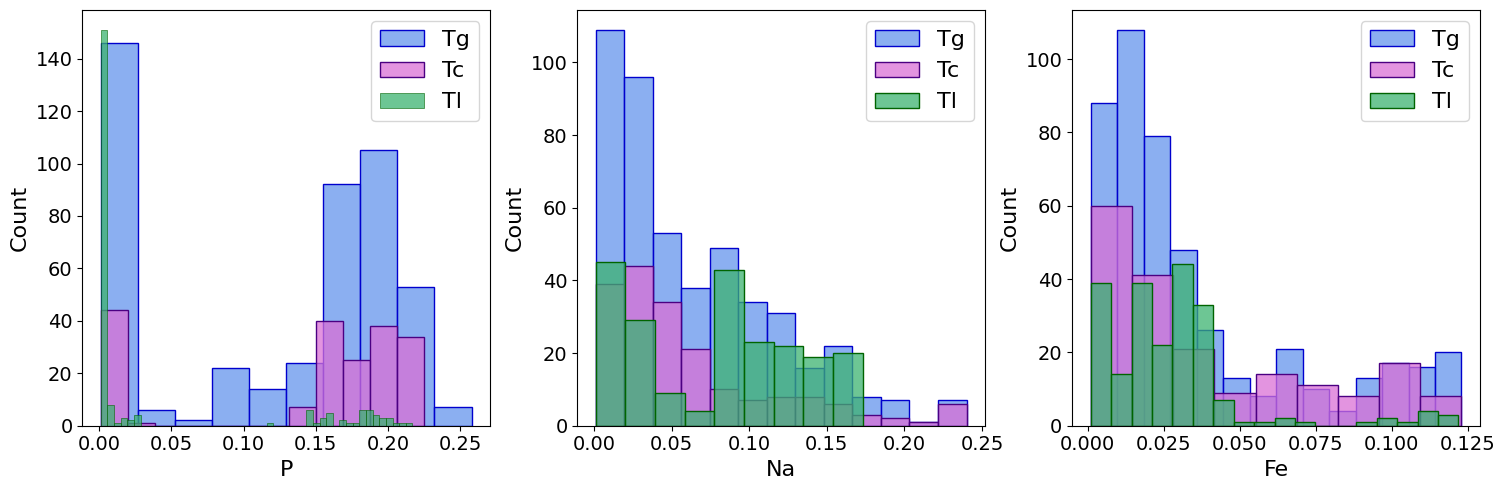

In [56]:
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
colors = ['cornflowerblue', 'orchid', 'mediumseagreen']
ecolors = ['mediumblue', 'indigo', 'darkgreen' ]
for j,el in enumerate( ['P', 'Na', 'Fe'] ):
    ax = axes[j]
    for i,col in enumerate( ['Tg', 'Tc', 'Tl'] ):
        this_y_glassnet = y_glassnet_total[ col ].dropna()
        this_X_glassnet = X_glassnet_total.loc[ this_y_glassnet.index, : ]
        this_X_na_p_fe = this_X_glassnet[ (this_X_glassnet['Na'] != 0) & (this_X_glassnet['Fe'] != 0) 
                   & (this_X_glassnet['P'] != 0 ) ]
        
        sns.histplot( this_X_na_p_fe[el], ax = ax, color = colors[i], edgecolor = ecolors[i], label = col )
    ax.legend()
fig.tight_layout()
fig.savefig('na_p_fe_counts.png', dpi=600)